# Read CSV to make diNT PWM used for looking up the scores

In [8]:
import csv

diNT_csv_dictionary = {}

#opens csv file, reads into a dictionary
with open('diNTpwm_fordict.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        diNT_csv_dictionary[row['dinucleotide'], row['position']] = row['efficiency']

# diNT PWM score TIS

``  1 , 2,  3,  4,  5,  6,  7 ``

`` -6, -5, -4, -3, -2, -1, +4, +5 ``


In [9]:
#have to scan through each dinucleotide position in seq
#get the efficiency and multiply together
#save into table

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO

import operator
import functools

import math



Load sequences into differnet TIS lists, from #30_ATG_rest and transcribe to RNA

In [10]:
viral_TIS_list = []
#get the sequence out of the fasta file # should start at 24 until 35
for viral_seq_record in SeqIO.parse("viral_all_30up_toSTOP.fasta", "fasta"):
    #transcribes from DNA to RNA by replacing T with U
    viral_TIS_list.append(viral_seq_record.seq[24:35].transcribe())
    
    
    
    
human_TIS_list = []
for human_seq_record in SeqIO.parse("hs_all_nodup_u36.fasta", "fasta"):
    human_TIS_list.append(human_seq_record.seq.upper()[30:41].transcribe())
    
    
    
        
gemini_TIS_list = []
for gemini_seq_record in SeqIO.parse("gemini_5utr_orf.fasta", "fasta"):
    gemini_TIS_list.append(gemini_seq_record.seq.upper()[29:40].transcribe())  

In [7]:
# above TIS_lists will be the input of below function

# extract diNT from TIS_list and discard common AUG

In [11]:
def diNT_tuple_gen(TIS_list):
    
    # MAKES A LIST OF DINT TUPLES FOR EACH TIS DISCARDING THE AUG - saves the diNT and its position
    seq_dint_tuple_list = []
    
    for i in range(len(TIS_list)):

        for j in range(0,5):
            seq_dint_tuple_list.append((str(TIS_list[i][j:j+2]), j+1))

        # add dint position 6
        seq_dint_tuple_list.append((TIS_list[i][5]+TIS_list[i][9], 6))


        # add dint position 7
        seq_dint_tuple_list.append((TIS_list[i][9]+TIS_list[i][10], 7))
    
    return seq_dint_tuple_list

# define PWM score lookup function

In [12]:
def PWM(dinucleotide, position):
    #convert efficiency into float
    return float(diNT_csv_dictionary[dinucleotide, position])

In [13]:
#first index is 0 to 6
#2nd index is from 0 to 1

#have to accumulate every 7 PWMs

def score_seq_with_PWM(seq_dint_tuple_list):
    
    PWM_diNT_scores_seq = []
    
    #loop through all the tuples in the dint tuple list
    for i in range(len(seq_dint_tuple_list)):
        
        #score each diNT, save the position and store into another list PWM_diNT_scores_seq
        PWM_diNT_scores_seq.append(PWM(seq_dint_tuple_list[i][0], str(seq_dint_tuple_list[i][1])))


    #group every 7 tuples which is a single sequence
    list_of_tuples_by_seven = [PWM_diNT_scores_seq[x:x+7] for x in range(0, len(PWM_diNT_scores_seq),7)]


    # have to multiply every 7 indices together to get single PWM score per sequence
    PWM_scores_seq = []
    for i in range(len(list_of_tuples_by_seven)):
        PWM_scores_seq.append(functools.reduce(operator.mul, list_of_tuples_by_seven[i], 7))
    
    return PWM_scores_seq


In [14]:
def convert_to_Pandas_series_adjust_K_val(PWM_scores_seq):
    #convert to pandas series, a datastructure, to easily manipulate
    pandas_PWM_scores = pd.Series(PWM_scores_seq)
    adjusted_PWM_scores = pandas_PWM_scores*math.exp(4.602730)
    
    return adjusted_PWM_scores

In [ ]:
plt.hist(adjusted_PWM_scores, bins = 200)
plt.show()

# diNT PWM scoring pipeline

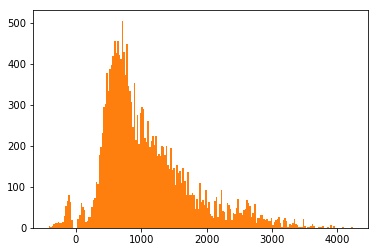

In [32]:
viral_diNT_tuples = diNT_tuple_gen(viral_TIS_list)
human_diNT_tuples = diNT_tuple_gen(human_TIS_list)
gemini_diNT_tuples = diNT_tuple_gen(gemini_TIS_list)

not_adjusted_viral_PWM_scores = score_seq_with_PWM(viral_diNT_tuples)
not_adjusted_human_PWM_scores = score_seq_with_PWM(human_diNT_tuples)
# score_seq_with_PWM(gemini_diNT_tuples) 
#messed up diNT "YA"


viral_data = convert_to_Pandas_series_adjust_K_val(not_adjusted_viral_PWM_scores)
human_data = convert_to_Pandas_series_adjust_K_val(not_adjusted_human_PWM_scores)

plt.hist(viral_data,bins = 200)
plt.hist(human_data, bins = 200)
plt.show()

# Randomize human TIS sequence

In [34]:
import numpy
import random
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio.Alphabet import generic_rna

#for human sequences make a new fresh list of TIS sequences
from Bio import SeqIO
rand_TIS_list = []
#get the sequence out of the fasta file # should start at 24 until 35
for rand_seq_record in SeqIO.parse("hs_all_nodup_u36.fasta", "fasta"):
    #transcribes from DNA to RNA by replacing T with U
    rand_TIS_list.append(rand_seq_record.seq.upper()[30:41].transcribe())

In [36]:
#rerun to get more random seq
shuffled_TIS_list =[]

for each in rand_TIS_list:
    
    #get the TIS only
    TIS_only = str(each[0:6] + each[9:11])
    
    #shuffles the TIS string
    shuffled_TIS_source_string = ''.join(random.sample(TIS_only,len(TIS_only)))
    
    shuffled_record = Seq(shuffled_TIS_source_string[0:6] + "AUG" + shuffled_TIS_source_string[6:8], 
            generic_rna)
    shuffled_TIS_list.append(shuffled_record)

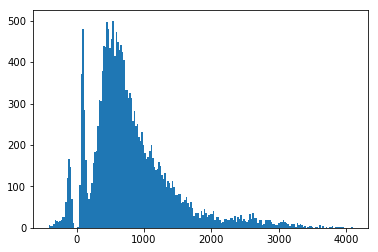

In [48]:
#rerun to get more random seq
shuffled_TIS_list =[]

for each in rand_TIS_list:
    
    #get the TIS only
    TIS_only = str(each[0:6] + each[9:11])
    
    #shuffles the TIS string
    shuffled_TIS_source_string = ''.join(random.sample(TIS_only,len(TIS_only)))
    
    shuffled_record = Seq(shuffled_TIS_source_string[0:6] + "AUG" + shuffled_TIS_source_string[6:8], 
            generic_rna)
    shuffled_TIS_list.append(shuffled_record)
    
    
    

    
scrambled_diNT_tuple_list = diNT_tuple_gen(shuffled_TIS_list)

scrambled_PWM_scores = score_seq_with_PWM(scrambled_diNT_tuple_list)

scrambled_human_data = convert_to_Pandas_series_adjust_K_val(scrambled_PWM_scores)

plt.hist(scrambled_human_data,bins=200)
plt.show()
    
# seq_dint_tuple_list = []
# for i in range(len(shuffled_TIS_list)):

#     for j in range(0,5):
#         seq_dint_tuple_list.append((str(shuffled_TIS_list[i][j:j+2]), j+1))

#     # add dint position 6
#     seq_dint_tuple_list.append((shuffled_TIS_list[i][5]+TIS_list[i][9], 6))


#     # add dint position 7
#     seq_dint_tuple_list.append((shuffled_TIS_list[i][9]+TIS_list[i][10], 7))
    

    
    #first index is 0 to 6
#2nd index is from 0 to 1

#have to accumulate every 7 PWMs

# PWM_diNT_scores_seq = []
# for i in range(len(seq_dint_tuple_list)):
#     PWM_diNT_scores_seq.append(PWM(seq_dint_tuple_list[i][0], str(seq_dint_tuple_list[i][1])))
    
# list_of_tuples_by_seven = [PWM_diNT_scores_seq[x:x+7] for x in range(0, len(PWM_diNT_scores_seq),7)]


# # have to multiply every 7 indices
    
# import operator
# import functools

# PWM_scores_seq = []
# for i in range(len(list_of_tuples_by_seven)):
#     PWM_scores_seq.append(functools.reduce(operator.mul, list_of_tuples_by_seven[i], 7))


# Plot density of diNT PWM scores

In [1]:
#plots densities of the efficiencies

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde



data_human = final_data_human

density_human = gaussian_kde(data_human)





data_viral = final_data_viral

density_viral = gaussian_kde(data_viral)


xs = np.linspace(-1000,4000,2000)






density_viral.covariance_factor = lambda : .25

density_viral._compute_covariance()









density_human.covariance_factor = lambda : .25

density_human._compute_covariance()


plt.plot(xs,density_viral(xs), label = "viral TIS")
plt.plot(xs,density_human(xs), label = "human TIS")
plt.legend()
plt.show()

#human

NameError: name 'final_data_human' is not defined